In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms , datasets  
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

In [7]:
# Define data path (replace with your actual path)
data_path = "/kaggle/input/abstract-art-gallery"  # Assuming Kaggle environment

# Define transformations (resize to 64x64, normalize to [-1, 1])
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load dataset
dataset = datasets.ImageFolder(root=data_path, transform=transform)

# Configure data loader with batch size and number of workers
data_loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2)

print("Abstract Art Gallery dataset loaded successfully!")


Abstract Art Gallery dataset loaded successfully!


In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt

# Define Generator
class Generator(nn.Module):
    def __init__(self, latent_dim, img_shape):
        super(Generator, self).__init__()
        self.img_shape = img_shape
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, img_shape[0] * img_shape[1] * img_shape[2]),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *self.img_shape)
        return img

# Define Discriminator
class Discriminator(nn.Module):
    def __init__(self, img_shape):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(img_shape[0] * img_shape[1] * img_shape[2], 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

# Define Loss Function
adversarial_loss = nn.BCELoss()

# Initialize Generator and Discriminator
latent_dim = 100
img_shape = (3, 64, 64)  # Change the shape according to your dataset
generator = Generator(latent_dim, img_shape)
discriminator = Discriminator(img_shape)

# GPU Setting
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator.to(device)
discriminator.to(device)

# Configure Data Loader
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataset = ImageFolder(root='/kaggle/input/abstract-art-gallery', transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Define Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training Loop
num_epochs = 50
g_losses = []
d_losses = []
for epoch in range(num_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # Adversarial ground truths
        valid = torch.ones(imgs.size(0), 1, device=device)
        fake = torch.zeros(imgs.size(0), 1, device=device)

        # Configure input
        real_imgs = imgs.to(device)

        # Train Generator
        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = torch.randn(imgs.size(0), latent_dim, device=device)

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())

        print(
            f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(dataloader)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]"
        )


[Epoch 0/50] [Batch 0/45] [D loss: 0.6936098337173462] [G loss: 0.6881570816040039]
[Epoch 0/50] [Batch 1/45] [D loss: 0.5532630085945129] [G loss: 0.8234457969665527]
[Epoch 0/50] [Batch 2/45] [D loss: 0.3978951573371887] [G loss: 0.9837979674339294]
[Epoch 0/50] [Batch 3/45] [D loss: 0.2875579595565796] [G loss: 1.1869806051254272]
[Epoch 0/50] [Batch 4/45] [D loss: 0.21713557839393616] [G loss: 1.3835253715515137]
[Epoch 0/50] [Batch 5/45] [D loss: 0.17745600640773773] [G loss: 1.5073037147521973]
[Epoch 0/50] [Batch 6/45] [D loss: 0.19004802405834198] [G loss: 1.5046522617340088]
[Epoch 0/50] [Batch 7/45] [D loss: 0.1830868422985077] [G loss: 1.3925690650939941]
[Epoch 0/50] [Batch 8/45] [D loss: 0.22155070304870605] [G loss: 1.2374556064605713]
[Epoch 0/50] [Batch 9/45] [D loss: 0.23272296786308289] [G loss: 1.1515889167785645]
[Epoch 0/50] [Batch 10/45] [D loss: 0.2404489815235138] [G loss: 1.1207408905029297]
[Epoch 0/50] [Batch 11/45] [D loss: 0.24414511024951935] [G loss: 1.11

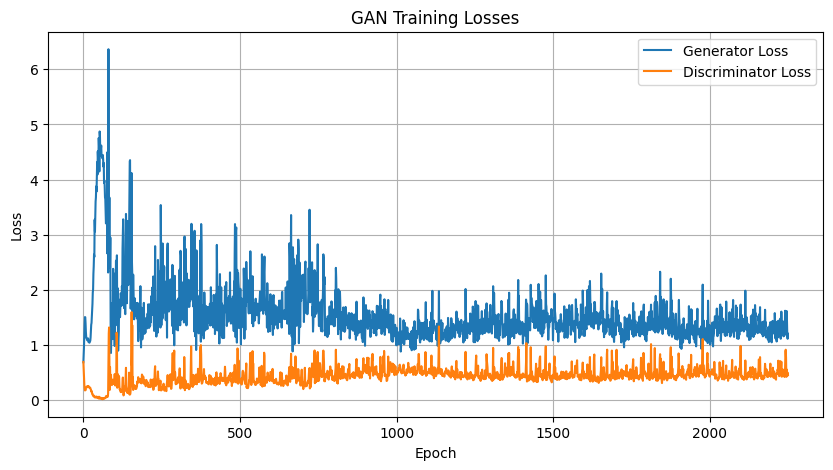

In [18]:
# Plot losses
plt.figure(figsize=(10, 5))
plt.plot(g_losses, label='Generator Loss')
plt.plot(d_losses, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GAN Training Losses')
plt.legend()
plt.grid(True)
plt.show()

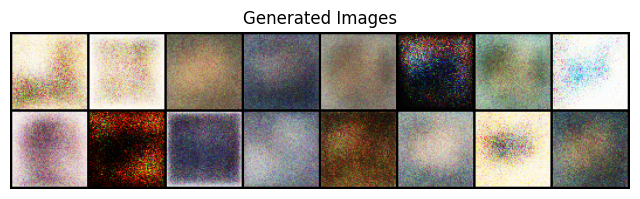

In [19]:
import torchvision.utils as vutils
import numpy as np

# Generate new data
num_samples = 16
z = torch.randn(num_samples, latent_dim, device=device)
with torch.no_grad():
    fake_images = generator(z).detach().cpu()

# Plot the generated images
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(vutils.make_grid(fake_images, padding=2, normalize=True), (1, 2, 0)))
plt.show()